# 2章 確率的プログラミング：コンピュータの助けを借りる

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 28 seconds.


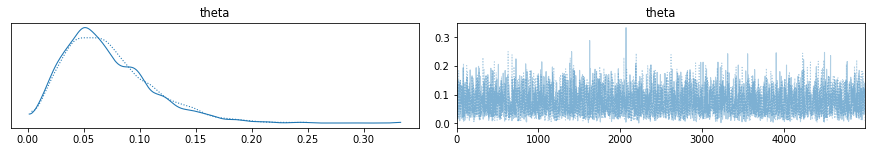

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz

N = 40  # アリスのデザインA案の表示数
a = 2   # アリスのデザインA案のクリック数

with pm.Model() as model:
    theta = pm.Uniform('theta', lower=0, upper=1)
    obs = pm.Binomial('a', p=theta, n=N, observed=a)
    trace = pm.sample(5000, chains=2)

with model:
    # pm.traceplot(trace) # traceplotはPyMC3 ver=3.11から削除されている
    # https://github.com/pymc-devs/pymc3/blob/master/RELEASE-NOTES.md#pymc3-3110-21-january-2021
    arviz.plot_trace(trace)

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
theta  0.071  0.039     0.009      0.149      0.001      0.0    4983.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
theta  4983.0    4338.0    4625.0    1.0  
定量的評価： 0.9906


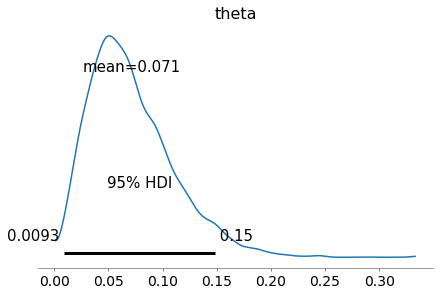

In [16]:
with model:
    # https://docs.pymc.io/api/stats.html
    print(arviz.summary(trace, hdi_prob=0.95))

with model:
    # https://docs.pymc.io/api/plots.html
    arviz.plot_posterior(trace, hdi_prob=0.95)

print('定量的評価：', (trace['theta'] - 0.01 > 0).mean()) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 35 seconds.
定量的評価： 0.6829


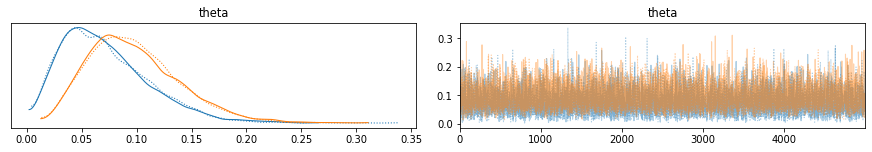

In [17]:
# アリスのデザイン案AおよびBのクリック率のサンプルの可視化
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1, shape=2)
  obs = pm.Binomial('obs', p=theta, n=[40, 50], observed=[2, 4])
  trace = pm.sample(5000, chains=2)

with model:
  arviz.plot_trace(trace, ['theta'], compact=True)

# A案 -> ['theta'][:, 0]
# B案 -> ['theta'][:, 1]
print('定量的評価：', (trace['theta'][:, 1] - trace['theta'][:, 0] > 0).mean())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 39 seconds.
定量的評価： 0.9995


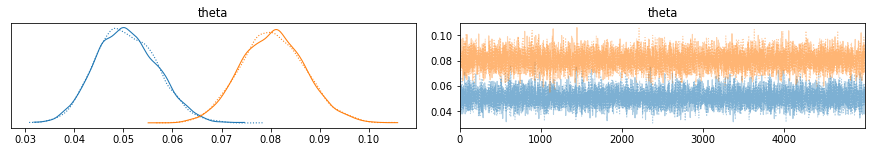

In [18]:
# ボブのデザイン案AおよびBのクリック率のサンプルの可視化
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1, shape=2)
  obs = pm.Binomial('obs', p=theta, n=[1280, 1600], observed=[64, 128])
  trace = pm.sample(5000, chains=2)
  print('定量的評価：', (trace['theta'][:, 0] < trace['theta'][:, 1]).mean())
  arviz.plot_trace(trace, ['theta'], compact=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 544 seconds.


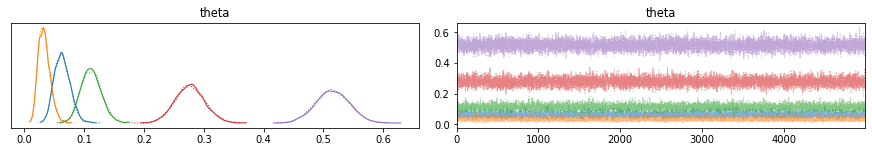

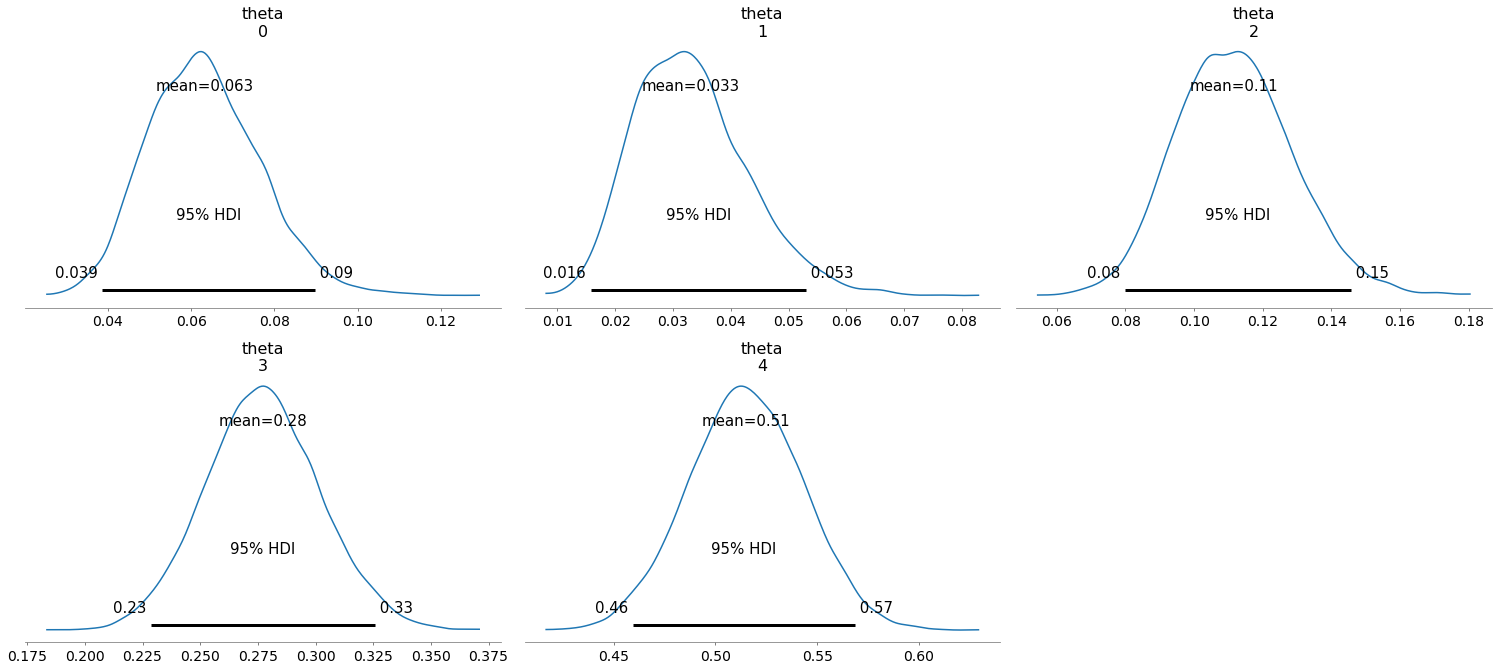

In [21]:
# 商品Aについて各レビュースコアが生み出される確率θ
n_a = [20, 10, 36, 91, 170]
data = [0 for _ in range(n_a[0])]
data += [1 for _ in range(n_a[1])]
data += [2 for _ in range(n_a[2])]
data += [3 for _ in range(n_a[3])]
data += [4 for _ in range(n_a[4])]

with pm.Model() as model_a:
  theta = pm.Dirichlet('theta', a=np.array([1, 1, 1, 1, 1]))
  obs = pm.Categorical('obs', p=theta, observed=data)
  trace_a = pm.sample(5000, chains=2)

  # サンプルの可視化
  arviz.plot_trace(trace_a)

  # 事後分布の可視化
  arviz.plot_posterior(trace_a, hdi_prob=0.95)

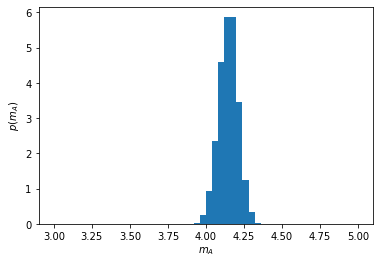

In [25]:
# 商品Aに対するレビュースコアの平均点の確率変数mの確率分布
weights = np.array([1, 2, 3, 4, 5])
# Numpy配列の操作にfor文使用はパフォーマンスの面からバッドプラクティス
# m_a = [sum(row * weights) for row in trace_a['theta']]
m_a = np.matmul(trace_a['theta'], weights)

plt.hist(m_a, range=(3, 5), bins=50, density=True)
plt.xlabel(r'$m_A$')
plt.ylabel(r'$p(m_A)$')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 192 seconds.


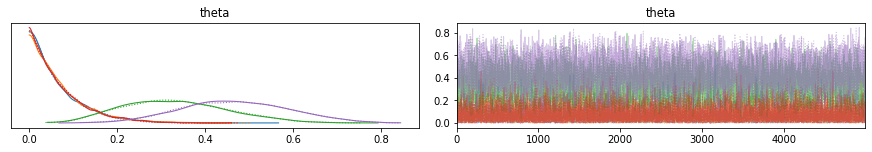

In [26]:
# 商品Bについて各レビュースコアが生み出される確率θのサンプルの可視化
n_b = np.array([0, 0, 4, 0, 6])
with pm.Model() as model_b:
  theta = pm.Dirichlet('theta', a=np.array([1, 1, 1, 1, 1]))
  obs = pm.Multinomial('obs', p=theta, n=n_b.sum(), observed=n_b)
  trace_b = pm.sample(5000, chains=2)
  arviz.plot_trace(trace_b)

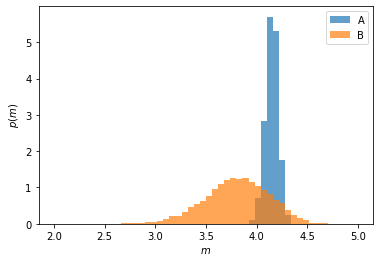

In [27]:
# 商品AとBのレビュースコアの平均点の確率密度関数
m_b = np.matmul(trace_b['theta'], weights)
plt.hist(m_a, range=(2, 5), bins=50, density=True, label='A', alpha=0.7)
plt.hist(m_b, range=(2, 5), bins=50, density=True, label='B', alpha=0.7)
plt.xlabel(r'$m$')
plt.ylabel(r'$p(m)$')
plt.legend()
plt.show()

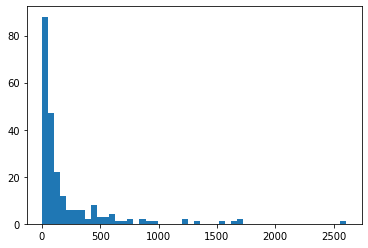

In [28]:
# あるウェブサイトにおける滞在時間（秒）のヒストグラム
import urllib
url = 'https://www.oreilly.co.jp/pub/9784873119168/data/time-on-page.csv'
response = urllib.request.urlopen(url)
data = [int(row.strip()) for row in response.readlines()]
plt.hist(data, bins=50)
plt.show()

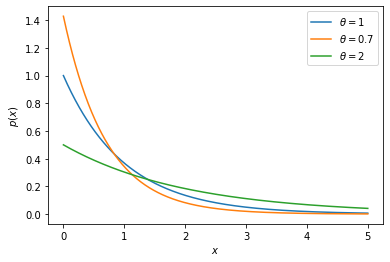

In [29]:
# さまざまな指数分布の例
from scipy import stats
xs = np.linspace(0, 5, 1001)
plt.plot(xs, stats.expon.pdf(xs, 0, 1), label=r'$\theta = 1$')
plt.plot(xs, stats.expon.pdf(xs, 0, 0.7), label=r'$\theta = 0.7$')
plt.plot(xs, stats.expon.pdf(xs, 0, 2), label=r'$\theta = 2$')
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$')
plt.legend()
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 90 seconds.


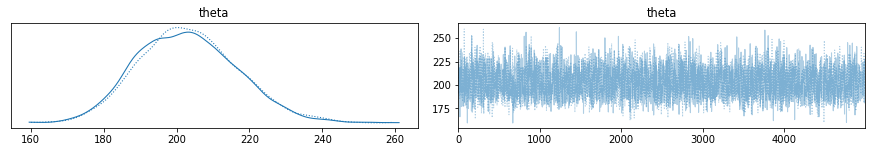

In [30]:
# 確率変数θのサンプルの軌跡
with pm.Model() as model:
    theta = pm.Uniform('theta', lower=0, upper=3000)
    obs = pm.Exponential('obs', lam=1/theta, observed=data)
    trace = pm.sample(5000, chains=2)
    arviz.plot_trace(trace)

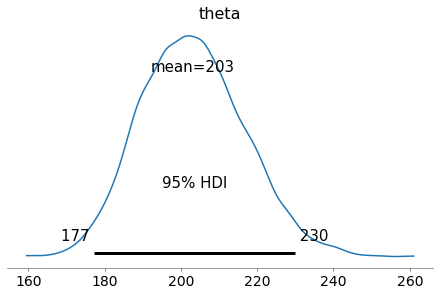

In [31]:
# 確率変数θの事後分布
with model:
    arviz.plot_posterior(trace, hdi_prob=0.95)

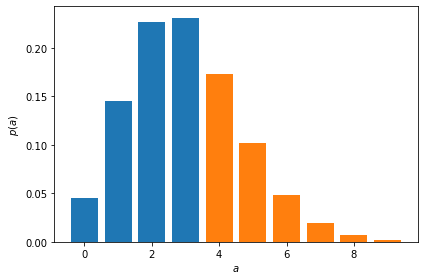

In [32]:
# アリスのレポートにおけるクリック数の標本分布（合計クリック数aが4以上となる部分が異なる色）
x = 10
N = 50
theta = 0.06
thres = 4
plt.bar(range(thres), stats.binom.pmf(range(thres), N, theta), linewidth=0)
plt.bar(range(thres, x), stats.binom.pmf(range(thres, x), N, theta), linewidth=0)
plt.xlabel(r'$a$')
plt.ylabel(r'$p(a)$')
plt.tight_layout()
plt.show()

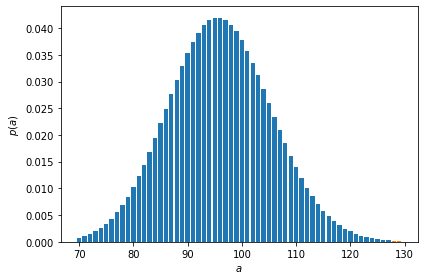

In [33]:
# ボブのレポートにおけるクリック数の標本分布（合計クリック数aが128以上となる部分が異なる色）
minx = 70
x = 130
N = 1600
theta = 0.06
thres = 128
plt.bar(range(minx, thres), stats.binom.pmf(range(minx, thres), N, theta), linewidth=0)
plt.bar(range(thres, x), stats.binom.pmf(range(thres, x), N, theta), linewidth=0)
plt.xlabel(r'$a$')
plt.ylabel(r'$p(a)$')
plt.tight_layout()
plt.show()